# World Modelers Demo #1
Benjamin M. Gyori, 7/13/2018

In [56]:
%matplotlib inline
import json
import numpy
import pandas
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [10, 8]
from collections import Counter
from IPython.display import Image
from pysb.simulator import ScipyOdeSimulator
from indra.sources import eidos; eidos.initialize_reader()
def df_from_counter(c, idx): return pandas.DataFrame.from_dict(cnt, orient='index').reset_index().rename(columns={'index': idx, 0:'count'})

### Import some INDRA modules

In [57]:
from indra.sources import eidos, bbn, sofia, cwms
from indra.assemblers import GraphAssembler, CAGAssembler, PysbAssembler
from indra.statements import Influence, Concept

# Simple text-to-model assembly
We first look at a simple example to the text to model assembly pipeline. The use case here assumes an expert who aims to rapidly prototype a model based on assumptions they describe in English language.
### Describe a model of food insecurity

In [58]:
text = """A significant increase in precipitation led to food insecurity and
to a decrease in humanitarian interventions. Actually, food insecurity itself can
lead to conflict, and in turn, conflict can drive food insecurity.
Generally, humanitarian interventions reduce conflict."""

### Read with Eidos via API, process into INDRA Statements

In [59]:
eidos_processor = eidos.process_text(text)
eidos_processor.statements

[Influence(humanitarian interventions(), conflict(negative)),
 Influence(food insecurity(), conflict()),
 Influence(precipitation(positive), food insecurity()),
 Influence(precipitation(positive), humanitarian interventions(negative)),
 Influence(conflict(), food insecurity())]

### Assemble into graph and draw

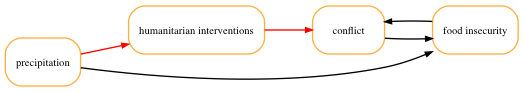

In [60]:
ga = GraphAssembler(eidos_processor.statements)
ga.make_model()
ga.save_pdf('text_to_model.png')
Image('text_to_model.png', width=800)

### Assemble into PySB/ODE model and simulate

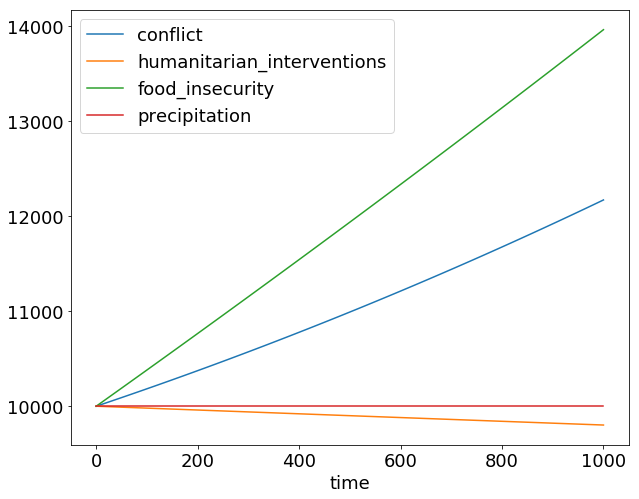

In [61]:
def assemble_pysb(stmts):
    pa = PysbAssembler()
    pa.add_statements(stmts)
    model = pa.make_model(reverse_effects=True)
    return model

def simulate_model(model, ts=None, pd=None):
    if not ts:
        ts = numpy.linspace(0, 1000, 100)
    sim = ScipyOdeSimulator(model, ts)
    if not pd:
        res = sim.run()
    else:
        res = sim.run(param_values=pd)
    df = res.dataframe
    df = df.rename(columns={'__s%d' % i: s.monomer_patterns[0].monomer.name
                            for i, s in enumerate(model.species)})
    return df

model = assemble_pysb(eidos_processor.statements)
df = simulate_model(model)
df.plot()

### Now let's see what happens in whe increase humanitarian intervention and decrease precipitation
Both conflict and food insecturity now decrease.

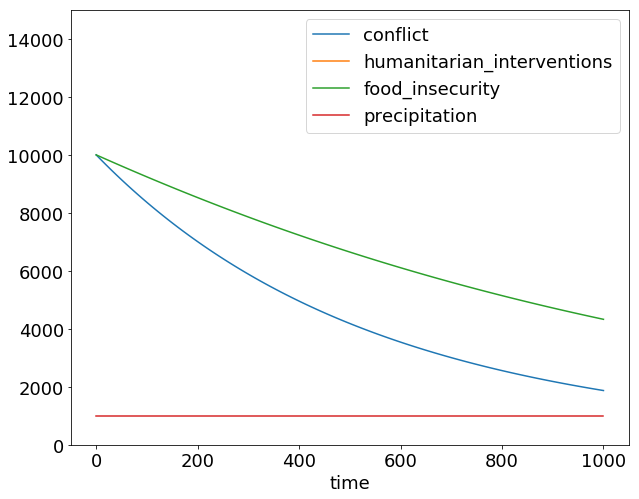

In [53]:
df = simulate_model(model, ts=None, pd={'humanitarian_interventions_0': 1e6, 'precipitation_0': 1e3,
                                        'kf_f_deg_1': 1e-3})
df.plot(ylim=[0, 15000])

### We can also modify the model simply by changing the text

In [54]:
text2 = text + ' Displacement causes food insecurity.'

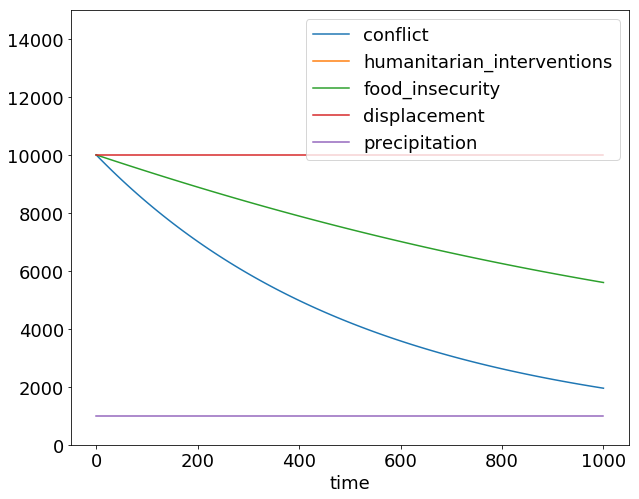

In [55]:
df = simulate_model(assemble_pysb(eidos.process_text(text2).statements),
                    ts=None, pd={'humanitarian_interventions_0': 1e6, 'precipitation_0': 1e3,
                                 'kf_f_deg_1': 1e-3})
df.plot(ylim=[0, 15000])

# Reading, assembly and modeling of food insecurity in South Sudan

In [62]:
from run_eval import *

In [63]:
# Get the IDs of all the documents in the docs folder
docnames = sorted(['.'.join(os.path.basename(f).split('.')[:-1])
                   for f in glob.glob('docs/*.txt')],
                   key=lambda x: int(x.split('_')[0]))
exclude = '31_South_Sudan_2018_Humanitarian_Needs_Overview'
docnames = [d for d in docnames if d != exclude]
print('Using %d documents' % len(docnames))

Using 51 documents


On another note: indra.literature.elsevier_client and indra.literature.newsapi_client can be used to query for and collect reading corpora on demand (e.g. we collected Elsevier-published papers discussing "food security + intervention")

In [64]:
eidos_stmts = read_eidos(docnames)
cwms_stmts = read_cwms_sentences(extract_eidos_text(docnames), read=False)
bbn_stmts = read_bbn('bbn/wm_m6_0626.json-ld')
sofia_stmts = read_sofia('sofia/MITRE_June18_v1.xlsx')

17 stmts from 1_IPC_Alert_9_SouthSudan_Sept2017
145 stmts from 2_IFPRI
75 stmts from 3_ALPAN_Paper_10
6 stmts from 4_FAO
193 stmts from 5_annurev-publhealth-031816-044356
8 stmts from 6_FAO_news
0 stmts from 7_South_Sudan_KeyMessages_Sept2017
19 stmts from 8_EA_Seasonal Monitor_2017_08_11
30 stmts from 9_FAOSS Livestock Crisis Update 2015
228 stmts from 10_FAO_a-i5505e
173 stmts from 11_FAO_a-i5591e
10 stmts from 12_SSD21-February-2017
9 stmts from 13_SSD_8
20 stmts from 14_SSD09-May-2017
24 stmts from 15_FEWS NET South Sudan Famine Risk Alert_20170117
9 stmts from 16_South Sudan - Key Message Update_ Thu, 2018-01-25
30 stmts from 17_FS2011-3072
6 stmts from 18_FFP Fact Sheet_South Sudan_2018.01.17
2 stmts from 19_wfp284277
3 stmts from 20_wfp287168
200 stmts from 21_i8343en
17 stmts from 22_IPC_South_Sudan_AcuteFI_May2017_June-July2017
2 stmts from 23_ipc_south_sudan_key_messages_feb2017
41 stmts from 24_pnas.201409769
136 stmts from 25_2016_HNO_South Sudan
205 stmts from 26_South_Sud

INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::PRODUCE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::GET
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::NO-CHANGE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::GET
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::ENSURE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::BY-MEANS-OF
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::GET
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::PRODUCE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::MOVE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::END
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::PRODUCE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::PRODUCE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::PRODUCE
INFO: [2018-07-13 14:47:26

INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::PRODUCE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::PRODUCE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::PRODUCE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::MOVE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::PRODUCE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::BY-MEANS-OF
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::CLIMATE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::PRODUCE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::BY-MEANS-OF
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::ENABLE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::BY-MEANS-OF
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::CANCEL
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::BY-MEANS-OF
I

INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::PRODUCE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::PRODUCE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::GET
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::GET
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::DESTROY
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::NO-CHANGE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::MOVE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::GET
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::MOVE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::GET
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::GET
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::BY-MEANS-OF
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::BY-MEANS-OF
INFO: [2018-07-13 14:47:26] 

INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::DESTROY
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::MOVE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::DEPENDENT
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::BY-MEANS-OF
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::BY-MEANS-OF
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::NO-CHANGE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::MOVE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::NO-CHANGE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::MOVE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::MOVE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::MOVE
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::GET
INFO: [2018-07-13 14:47:26] indra/cwms - Unhandled event type: ONT::GET
INFO: [2018-07-13 14:

INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::END
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::MOVE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::DESTROY
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::MOVE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::MOVE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::MOVE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::NO-CHANGE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::DESTROY
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::NO-CHANGE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::END
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::DEPENDENT
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::DISEASE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::BY-MEANS-OF
INFO: [2018-07-13 14:4

INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::NO-CHANGE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::NO-CHANGE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::GET
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::GET
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::NO-CHANGE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::MOVE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::PRODUCE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::GET
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::MOVE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::GET
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::GET
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::ENABLE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::NO-CHANGE
INFO: [2018-07-13 14:47:27] ind

INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::PRODUCE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::PRODUCE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::MOVE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::MOVE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::MOVE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::MOVE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::PRODUCE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::DESTROY
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::MOVE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::MOVE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::MOVE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::PRODUCE
INFO: [2018-07-13 14:47:27] indra/cwms - Unhandled event type: ONT::MOVE
INFO: [2018-07-13 14:47:27] indra/cw

We simply concatenate Statements from different sources - power of common knowledge representation!

In [65]:
statements = eidos_stmts + cwms_stmts + bbn_stmts + sofia_stmts
print('%d total statements' % len(statements))

4201 total statements


Let's plot how many raw Statements we get from each source

<BarContainer object of 4 artists>

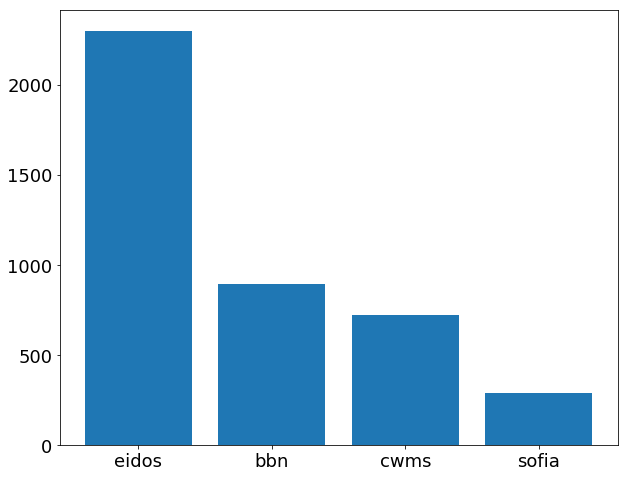

In [66]:
source_cnt = sorted(Counter([st.evidence[0].source_api for st in statements]).items(),
                    key=lambda x: x[1], reverse=True)
plt.bar(*zip(*source_cnt))

Statements can be inspected manually / programmatically, and also serve as an exchange format

In [67]:
eidos_stmts[2]

Influence(food insecurity(), population())

In [68]:
eidos_stmts[2].evidence[0].text

'food insecurity is affecting the population'

In [69]:
eidos_stmts[2].subj.db_refs

{'TEXT': 'food insecurity',
 'UN': [('UN/entities/human/food/food_insecurity', 0.778000176679367),
  ('UN/entities/human/food/food_security', 0.7391947521416266),
  ('UN/events/human/famine', 0.6420612664706928),
  ('UN/entities/human/financial/economic/poverty', 0.616514061032048),
  ('UN/entities/natural/crop_technology', 0.6119867400453652),
  ('UN/entities/human/health/human_health', 0.5918928567884209),
  ('UN/entities/human/livelihood', 0.5901297377723462),
  ('UN/events/human/intervention/intervention', 0.5274700842171258),
  ('UN/events/natural/natural_resources', 0.514556098358835),
  ('UN/entities/human/communities', 0.5131870936420381)]}

In [70]:
print(json.dumps(eidos_stmts[1].to_json(), indent=1))

{
 "type": "Influence",
 "subj": {
  "name": "constraint",
  "db_refs": {
   "TEXT": "humanitarian access constraints",
   "UN": [
    [
     "UN/events/nature_impact/negative_nature_impact",
     0.3199074005266926
    ],
    [
     "UN/entities/human/food/food_insecurity",
     0.3180766178574775
    ],
    [
     "UN/entities/human/financial/economic/economy",
     0.31535406115162923
    ],
    [
     "UN/entities/human/government/government_actions",
     0.3099001793955453
    ],
    [
     "UN/events/human/intervention/intervention",
     0.3000368498625746
    ],
    [
     "UN/events/nature_impact/positive_nature_impact",
     0.2947675078059365
    ],
    [
     "UN/entities/human/financial/economic/technology",
     0.279050514184315
    ],
    [
     "UN/events/human/human_migration",
     0.27772043587247025
    ],
    [
     "UN/events/natural/biology/ecosystem",
     0.2617645957734532
    ],
    [
     "UN/entities/natural/crop_technology",
     0.2586368489283333
    ]

Let's now start assembly for real

First, let's filter out Statements with unreliably grounded or ungrounded concepts

In [71]:
statements = ac.filter_grounded_only(statements, score_threshold=0.7)

INFO: [2018-07-13 14:50:31] indra/assemble_corpus - Filtering 4201 statements for grounded agents...
INFO: [2018-07-13 14:50:31] indra/assemble_corpus - 2354 statements after filter...


Next, we map grounding between ontologies

In [72]:
statements = map_onto(statements)

Let's look at a specific example

In [73]:
statements[0].subj.db_refs

{'BBN': 'event/healthcare/famine',
 'CWMS': 'ONT::UNSAFE-SCALE|ONT::FOOD',
 'SOFIA': 'Health/Famine',
 'TEXT': 'food insecurity',
 'UN': [('UN/entities/human/food/food_insecurity', 0.778000176679367),
  ('UN/entities/human/food/food_security', 0.7391947521416266),
  ('UN/events/human/famine', 0.6420612664706928),
  ('UN/entities/human/financial/economic/poverty', 0.616514061032048),
  ('UN/entities/natural/crop_technology', 0.6119867400453652),
  ('UN/entities/human/health/human_health', 0.5918928567884209),
  ('UN/entities/human/livelihood', 0.5901297377723462),
  ('UN/events/human/intervention/intervention', 0.5274700842171258),
  ('UN/events/natural/natural_resources', 0.514556098358835),
  ('UN/entities/human/communities', 0.5131870936420381)]}

We see here that the original string "food security" is grounded to the UN, BBN, SOFIA and CWMS ontologies simultaneously.

We tabulate each Concept by the ontologies it is grounded to. This shows that the majority of Concepts are now grounded to multiple ontologies, with 2500+ grounded to at least 3 ontologies.

In [74]:
cnt = Counter([tuple(sorted(list(set(conc.db_refs.keys())-{'TEXT'})))
                             for stmt in statements for conc in stmt.agent_list()])
df_from_counter(cnt, 'Grounding')

,Grounding,count
0,"(BBN, CWMS, SOFIA, UN)",350
1,"(BBN, SOFIA, UN)",2282
2,"(UN,)",176
3,"(CWMS,)",1345
4,"(CWMS, UN)",95
5,"(BBN,)",460


Now that we mapped ontologies, let's filter Statements by _relevance_ with respect ot a list of UN terms.

In [75]:
statements = ac.filter_by_db_refs(statements, 'UN',
    ['conflict', 'food_security', 'precipitation'], policy='one',
    match_suffix=True)

INFO: [2018-07-13 14:53:56] indra/assemble_corpus - Filtering 2354 statements for those with one agents grounded to: conflict, food_security, precipitation in the UN namespace...
INFO: [2018-07-13 14:53:56] indra/assemble_corpus - 780 Statements after filter...


We make an assembly assumption in which we assume implicit positive polarity for influences where the _subject_ polarity is not explicit. We then filter out any remaining Statements that don't have both subject and object polarity set.

In [76]:
assume_polarity(statements)
statements = filter_has_polarity(statements)

461 statements after polarity filter


Next, we run "preasembly" on the set of Statements. We first construct a joint hierarchy of all the reader ontologies.

In [77]:
def get_joint_hierarchies():
    eidos_ont = os.path.join(os.path.abspath(eidos.__path__[0]),
                             'eidos_ontology.rdf')
    trips_ont = os.path.join(os.path.abspath(cwms.__path__[0]),
                             'trips_ontology.rdf')
    bbn_ont = os.path.join(os.path.abspath(bbn.__path__[0]),
                           'bbn_ontology.rdf')
    hm = HierarchyManager(eidos_ont, True, True)
    hm.extend_with(trips_ont)
    hm.extend_with(bbn_ont)
    hierarchies = {'entity': hm}
    return hierarchies
hierarchies = get_joint_hierarchies()

The code below is usually a one-liner but here we break it up into multiple parts to show exactly what happens.

In [79]:
# Combine duplicates with the Preassembler
pa = Preassembler(hierarchies, statements)
unique_stmts = pa.combine_duplicates()
print('%d unique statements' % len(unique_stmts))
# Run the BeliefEngine with prior probabilities
be = BeliefEngine()
be.set_prior_probs(unique_stmts)
# Combine hierarchically-related Statements with the Preassembler
related_stmts = pa.combine_related(return_toplevel=False)
# Propagate beliefs over the hierarchy graph
be.set_hierarchy_probs(related_stmts)

223 unique statements
INFO: [2018-07-13 14:56:31] indra/preassembler - Preassembling Influence (223)


We can now filter for belief above 0.8 and get only the top-level Statements in the hierarchy

In [80]:
statements = ac.filter_belief(related_stmts, 0.8)
top_stmts = ac.filter_top_level(statements)
print('%d top-level statements' % len(top_stmts))

INFO: [2018-07-13 14:56:43] indra/assemble_corpus - Filtering 223 statements to above 0.800000 belief
INFO: [2018-07-13 14:56:43] indra/assemble_corpus - 81 statements after filter...
INFO: [2018-07-13 14:56:43] indra/assemble_corpus - Filtering 81 statements for top-level...
INFO: [2018-07-13 14:56:43] indra/assemble_corpus - 81 statements after filter...
81 top-level statements


&uparrow; This set of Statements is the input to Demo 3

The sources of individual pieces of evidence that contribute to Statements overall:

In [81]:
cnt = Counter([ev.source_api for stmt in top_stmts for ev in stmt.evidence])
df_from_counter(cnt, 'Source')

,Source,count
0,bbn,204
1,cwms,25
2,eidos,66
3,sofia,14


In [82]:
cnt = Counter([tuple(sorted(list({ev.source_api for ev in stmt.evidence}))) for stmt in top_stmts])
df_from_counter(cnt, 'Sources')

,Sources,count
0,"(bbn,)",36
1,"(cwms,)",8
2,"(eidos,)",20
3,"(bbn, cwms)",2
4,"(sofia,)",5
5,"(eidos, sofia)",1
6,"(bbn, eidos)",7
7,"(bbn, cwms, eidos)",1
8,"(bbn, sofia)",1


Let's pick one Statement and look at its evidence sentences in detail

In [83]:
stmt = [s for s in top_stmts if len(s.evidence) == 16][0]
print(stmt)
print('======')
print('"%s": %s' % (stmt.subj.db_refs['TEXT'], stmt.subj.db_refs['UN'][0][0]))
print('"%s": %s' % (stmt.obj.db_refs['TEXT'], stmt.obj.db_refs['UN'][0][0]))
print('======')
for ev in sorted(stmt.evidence, key=lambda x: x.text):
    print('%s: %s' % (ev.source_api.upper(), ev.text))
    print('--')

Influence(extreme  concern(positive), their ability to cultivate, search for  wild  foods, or  moved towards Wau town for assistance(negative))
"extreme  concern": UN/events/human/conflict
"their ability to cultivate, search for 
wild  foods, or  moved towards Wau town for assistance": UN/events/human/intervention/intervention
BBN: Across  much  of  the  country,  household access to food and cash income has declined as conflict has disrupted planting, harvesting, and other livelihood  activities.
--
BBN: Attacks on aid workers and destruction and looting  of assets have forced hundreds of aid workers to relocate,  disrupting services to affected people.
--
BBN: Food security has not improved significantly in October in central and southern Unity as conflict continues to disrupt normal  livelihood activities.
--
BBN: However,  some  households  did  not  plant  and  conflict  continues  to  limit  food  security  improvements  even during the harvest.
--
BBN: However, it is expected so

We can also find contradictions

In [84]:
standardize_names(top_stmts)
pa.stmts = top_stmts
contradictions = pa.find_contradicts()
for c1, c2 in contradictions:
    print('%s\n <-> %s\n' % (c1, c2))

Influence(Food insecurity(positive), Conflict(negative))
 <-> Influence(Food insecurity(positive), Conflict(positive))

Influence(Food security(positive), Conflict(negative))
 <-> Influence(Food security(positive), Conflict(positive))

Influence(Conflict(positive), Market(negative))
 <-> Influence(Conflict(positive), Market(positive))

Influence(Conflict(positive), Agriculture production(negative))
 <-> Influence(Conflict(positive), Agriculture production(positive))

Influence(Conflict(positive), Education(negative))
 <-> Influence(Conflict(positive), Education(positive))

Influence(Conflict(positive), Food insecurity(negative))
 <-> Influence(Conflict(positive), Food insecurity(positive))

Influence(Conflict(positive), Food security(negative))
 <-> Influence(Conflict(positive), Food security(positive))

Influence(Conflict(positive), Crisis(negative))
 <-> Influence(Conflict(positive), Crisis(positive))

Influence(Conflict(positive), Intervention(negative))
 <-> Influence(Conflict(posi

How can we decide between alternatives?
1. Often an "apparent" conflict is resolved by additional temporal or spatial context
2. We can expose these to the user an let them decide
3. In some cases both can be left in the model and data can implicitly prioritize
4. We can decide based on relative belief

In [85]:
contradictions[0][0].belief, contradictions[0][1].belief

(0.9419, 0.979665)

### Now let's move on to model assembly

In [86]:
model = assemble_pysb(top_stmts)

This model works and can be simulated but it's not parameterized! Demo 3 covered methods to automatically parameterize models via gradable adjectives and indicators.

In [87]:
res_df = simulate_model(model)

In [88]:
res_df[['Conflict', 'Food_insecurity', 'Crop_technology']]

,Conflict,Food_insecurity,Crop_technology
time,,,
0.000000,10000.000000,10000.000000,10000.000000
10.101010,10234.610984,10058.944865,10018.238622
20.202020,10469.724840,10118.559356,10036.583212
30.303030,10705.360150,10178.860783,10055.036539
40.404040,10941.523016,10239.850952,10073.598917
50.505051,11178.221607,10301.532193,10092.270759
60.606061,11415.459029,10363.905388,10111.052225
70.707071,11653.244139,10426.972961,10129.943756
80.808081,11891.581758,10490.736260,10148.945599


We can also use INDRA's explanation module and the ModelChecker to find paths that satisfy a given set of overall Influences (with polarities).

In [89]:
from indra.explanation.model_checker import PysbModelChecker
to_check = Influence(Concept('Precipitation'), Concept('Food_insecurity'))
mc = PysbModelChecker(model, statements=[to_check])
mc.prune_influence_map()
paths = mc.check_model(max_paths=10)
paths

INFO: [2018-07-13 15:01:07] indra/pysb_assembler - No monomer found corresponding to agent Food_insecurity
INFO: [2018-07-13 15:01:07] indra/model_checker - Generating influence map
INFO: [2018-07-13 15:01:07] indra/model_checker - Removing self loops
INFO: [2018-07-13 15:01:07] indra/model_checker - Get successorts of each node
INFO: [2018-07-13 15:01:07] indra/model_checker - Compare combinations of successors
INFO: [2018-07-13 15:01:07] indra/model_checker - Removing 20 edges from influence map
INFO: [2018-07-13 15:01:07] indra/model_checker - Checking stmt: Influence(Precipitation(), Food_insecurity())
INFO: [2018-07-13 15:01:07] indra/model_checker - Running path finding with max_paths=10, max_path_length=5
INFO: [2018-07-13 15:01:07] indra/model_checker - Finding paths between Precipitation() and Food_insecurity__obs with polarity 1
INFO: [2018-07-13 15:01:07] indra/model_checker - Finding paths between Precipitation() and Food_insecurity__obs with polarity 1


[(Influence(Precipitation(), Food_insecurity()), 
  PathResult:
      path_found: True
      result_code: PATHS_FOUND
      path_metrics: 
          0: source_node: Precipitation_produces_Food_insecurity, target_node: Food_insecurity__obs, polarity: 1, length: 1
          1: source_node: Precipitation_produces_Conflict, target_node: Food_insecurity__obs, polarity: 1, length: 2
          2: source_node: Precipitation_produces_Conflict, target_node: Food_insecurity__obs, polarity: 1, length: 3
          3: source_node: Precipitation_produces_Market, target_node: Food_insecurity__obs, polarity: 1, length: 3
          4: source_node: Precipitation_produces_Inflation, target_node: Food_insecurity__obs, polarity: 1, length: 3
          5: source_node: Precipitation_produces_Food_insecurity, target_node: Food_insecurity__obs, polarity: 1, length: 3
          6: source_node: Precipitation_degrades_Intervention, target_node: Food_insecurity__obs, polarity: 1, length: 3
          7: source_node:

&uparrow; this is a powerful explanation finding tool:

"in what ways could increased precipitation have resulted in reduced food security?"

but for now, we can use it for debugging, i.e. "do the ways in which Precipitation affects Food insecurity in the model make sense?". In a lot of the cases, clearly, no, and these are easily identifiable in a problem-driven way here (i.e. focus on problems in the model that matter).

Finally, let's look at an integrated simulation of the model with Topoflow in a relevant context.

In [90]:
from indra.assemblers.bmi_wrapper import BMIModel
model.name = 'indra_eval_model'
bmi_model = BMIModel(model)
out_name_maps = {'atmosphere_water__rainfall_volume_flux':            
                 'Precipitation'}                                     
input_vars = ['Precipitation']
bm = BMIModel(model, inputs=input_vars, stop_time=10000,           
              outside_name_map=out_name_maps)
bmi_model.export_into_python()

Topoflow is configured with precipitation for the Gel-Aliab basin

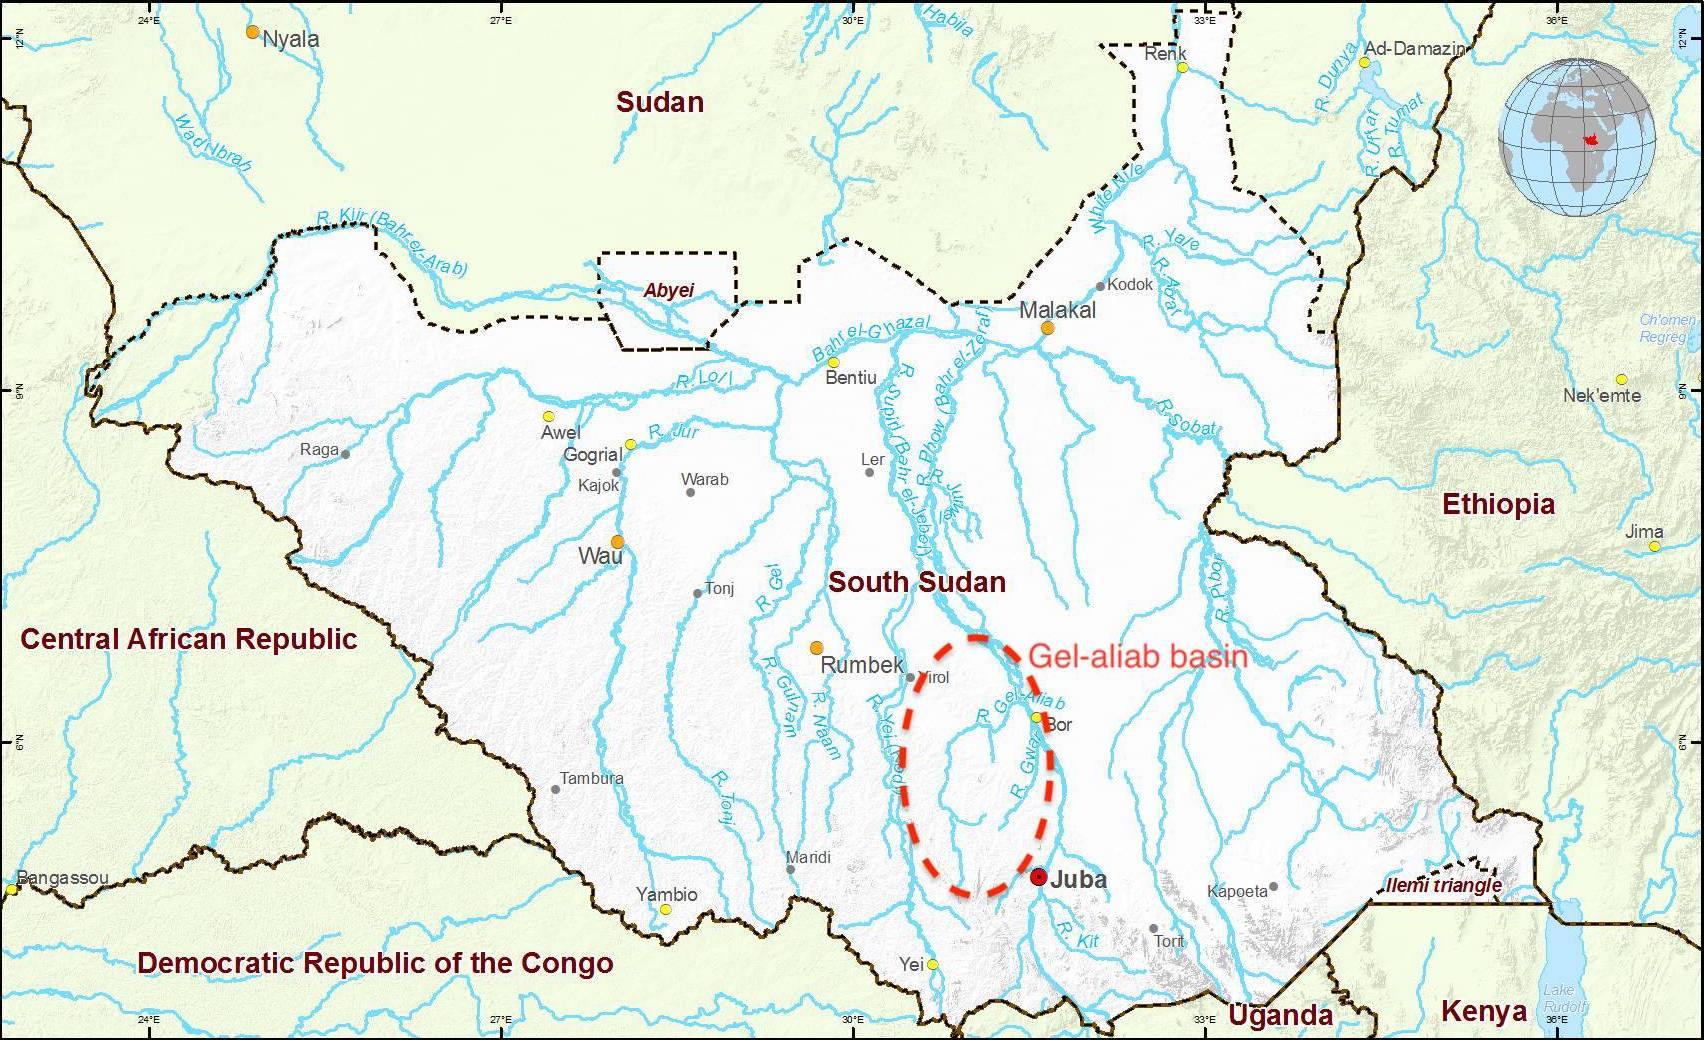

In [91]:
Image('demo/rivers.jpg', retina=True)

We now use this configuration of Topoflow and simulate it together with the model we just assembled.

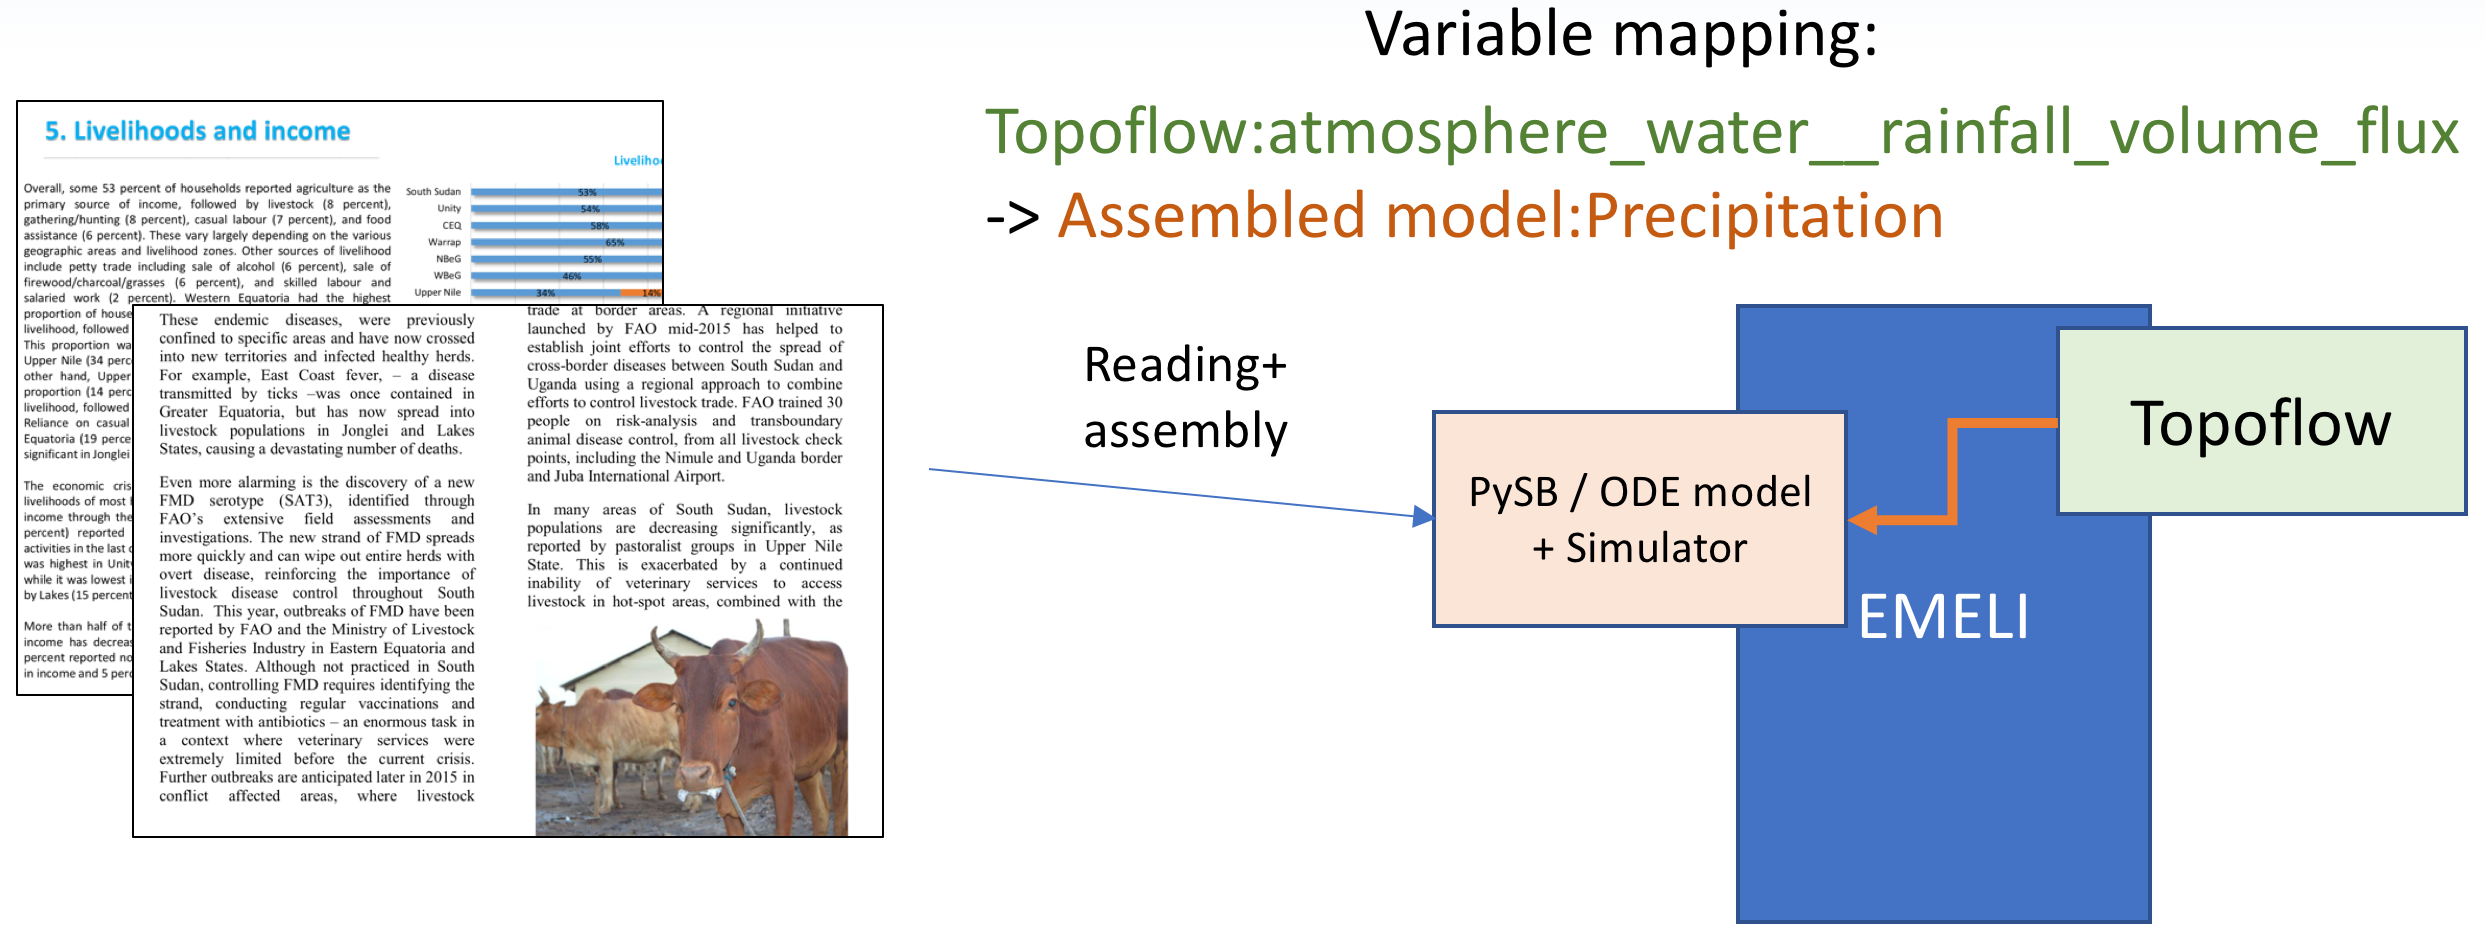

In [92]:
Image('demo/emeli_integ.png')

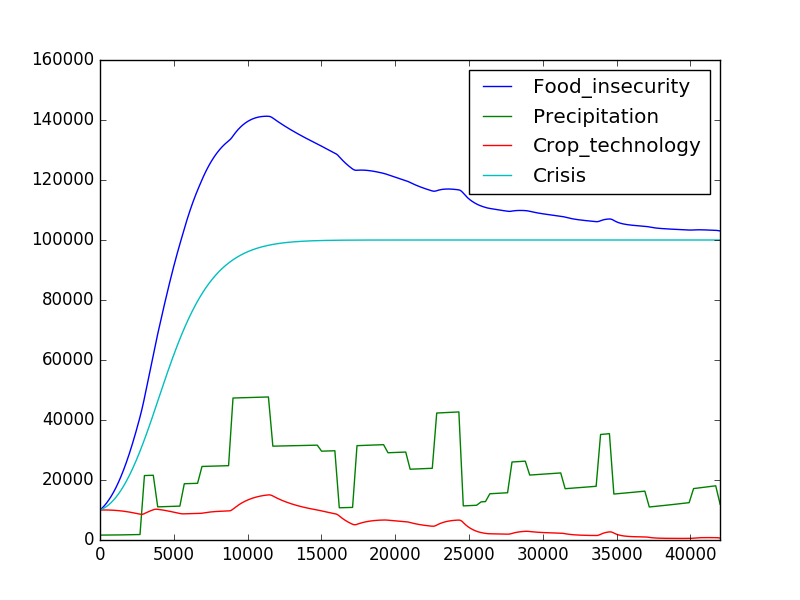

In [93]:
Image('demo/topoflow_simul.png')